In [1]:
import numpy as np
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from time import perf_counter
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
#%matplotlib inline

## Creating Data

Let's look at a cloud of data points surrounded by a circle. For this example, for each entry in the inner cloud is drawn from a $N(0,0.01)$, and each entry of the outer circle is sampled from a unit circle, with $N(0,0.01)$ noise added to each coordinate.

In [2]:
sampling_size = 100

sample = np.arange(sampling_size) * (np.pi/50)
outer_cloud = np.concatenate((np.expand_dims(np.cos(sample),1), np.expand_dims(np.sin(sample),1)), axis=1) + 0.1 * np.random.randn(sampling_size, 2)

inner_cloud = 0.1 * np.random.randn(sampling_size,2)

data = np.concatenate((outer_cloud, inner_cloud), axis=0)
colormap = np.concatenate((np.zeros(sampling_size),np.ones(sampling_size)))

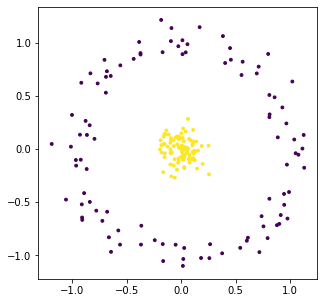

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(data.T[0], data.T[1], s=8, c=colormap)


### Some embeddings of this data

In [4]:
emb = np.empty((5, 2*sampling_size, 2))

In [5]:
emb[0] = KernelPCA(n_components=2, kernel='linear').fit_transform(data)
emb[1] = KernelPCA(n_components=2, kernel='poly').fit_transform(data)
emb[2] = KernelPCA(n_components=2, kernel='rbf').fit_transform(data)
emb[3] = KernelPCA(n_components=2, kernel='sigmoid').fit_transform(data)
emb[4] = KernelPCA(n_components=2, kernel='cosine').fit_transform(data)

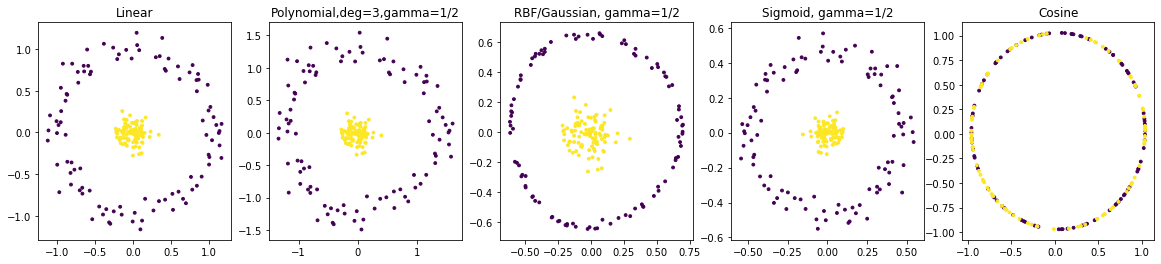

In [6]:
desc = ['Linear','Polynomial,deg=3,gamma=1/2', 'RBF/Gaussian, gamma=1/2', 'Sigmoid, gamma=1/2', 'Cosine']

fig,axes = plt.subplots(1,5, figsize=(20,4))
for i,ax in enumerate(axes.flat):
    ax.scatter(emb[i].T[0], emb[i].T[1], s=8, c=colormap)
    ax.set_title(desc[i])


### Varying Gamma for RBF (Gaussian) Kernel

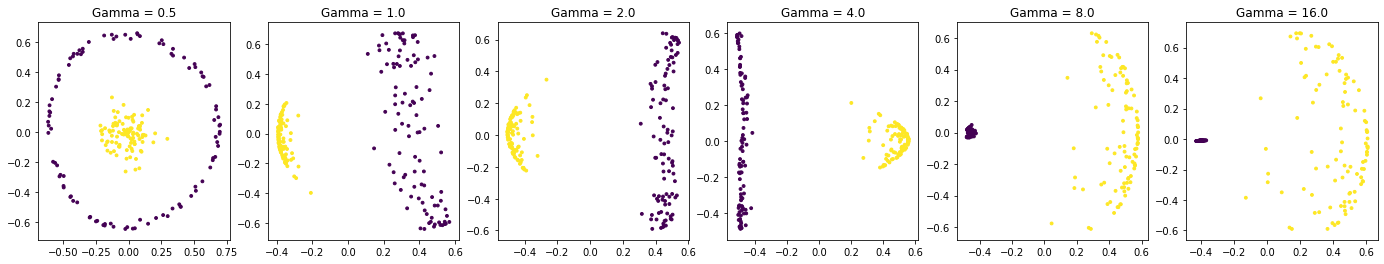

In [7]:
gamma_vals = np.asarray([0.5, 1, 2, 4, 8, 16])

emb = np.empty((gamma_vals.shape[0], 2*sampling_size, 2))

for i in range(gamma_vals.shape[0]):
    emb[i] = KernelPCA(n_components=2, kernel='rbf', gamma=gamma_vals[i]).fit_transform(data)

fig,axes = plt.subplots(1,gamma_vals.shape[0], figsize=(4*gamma_vals.shape[0],4))
for i,ax in enumerate(axes.flat):
    ax.scatter(emb[i].T[0], emb[i].T[1], s=8, c=colormap)
    ax.set_title(f"Gamma = {gamma_vals[i]}")


# Randomized KPCA

We can add randomness into Kernel PCA in two main ways:

- Using randomness to lower the dimensionality of the data matrix, similarly to RSVD
- Using randomness in the kernel function

First we attempt the second

In [8]:
def RKPCA(data, n_components, m):
    X = np.copy(data)       # n x d
    n = X.shape[0] # number of data pts
    d = X.shape[1] # dimensionality of data
    b = np.random.uniform(low=0, high = 2*np.pi, size=(1,m))
    W = np.random.multivariate_normal(mean=np.zeros(d), cov=(2/784)*np.eye(d), size=m) # m x d
    Z = np.empty((n,m))
    Z = np.cos(X @ W.T + b) # n x m
    K = 1/m * Z @ Z.T
    return KernelPCA(n_components=n_components, kernel='precomputed').fit_transform(K)

In [9]:
def plot(embedding, color_labels):
    if(embedding.shape[1] == 2):
        %matplotlib inline
        plt.scatter(embedding.T[0],embedding.T[1],s=8,c=color_labels)
        plt.show()
    elif(embedding.shape[1]==3):
        %matplotlib notebook
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(embedding.T[0],embedding.T[1],embedding.T[2], s=8, c=color_labels)
        plt.show()
    else:
        raise ValueError

In [10]:
#%matplotlib inline
X = data       # n x d

n = X.shape[0] # number of data pts
d = X.shape[1] # dimensionality of data

m = 10          # low dimension m << n
b = np.zeros((1,m))#np.random.uniform(low=0, high = 2*np.pi, size=(1,m))


In [11]:
start = perf_counter()
W = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=m) # m x d
Z = np.empty((n,m))
Z = np.cos(X @ W.T + b) # n x m
K = 1/m * Z @ Z.T

Text(0.5, 1.0, 'Random KPCA')

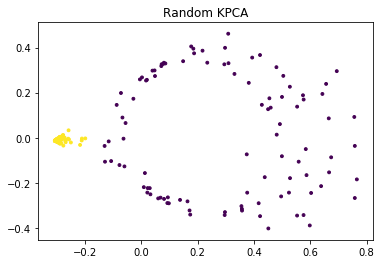

In [12]:
emb = KernelPCA(n_components=2, kernel='precomputed').fit_transform(K)
end = perf_counter()
t2 = end-start
#start = perf_counter()
#_ = KernelPCA(n_components=2, kernel='rbf', gamma=2).fit_transform(data)
#end = perf_counter()
t1 = end-start
plt.scatter(emb.T[0],emb.T[1], s=8, c=colormap)
plt.title('Random KPCA')

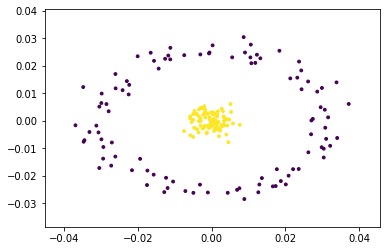

In [13]:
plot(RKPCA(data, 2, 10), colormap)

In [14]:
print(t1,t2)

0.016975900000000266 0.016975900000000266


## Experiments on MNIST 

In [15]:
mnist = pd.read_csv('../datasets/mnist/train.csv')

full_X = mnist[mnist.columns[1:]].values / 255
full_y = mnist.label.values

X = full_X[:1000]
y = full_y[:1000]

print(X.shape)


(1000, 784)


### KPCA with polynomial kernel

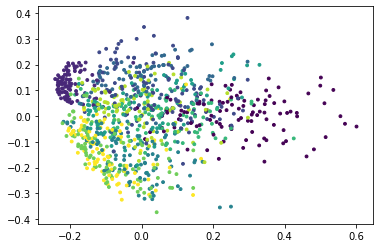

In [16]:
%matplotlib inline
emb = KernelPCA(n_components=2, kernel='poly').fit_transform(X)
plt.scatter(emb.T[0],emb.T[1],s=8,c=y)

### KPCA with gaussian kernel

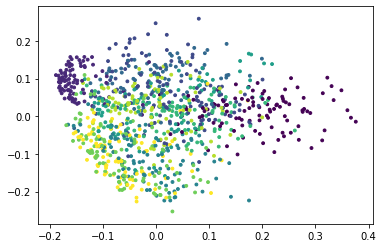

In [17]:
%matplotlib inline
emb = KernelPCA(n_components=2, kernel='rbf').fit_transform(X)
plt.scatter(emb.T[0],emb.T[1],s=8,c=y)

### RKPCA emulating gaussian kernel

C:\Users\Sean\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


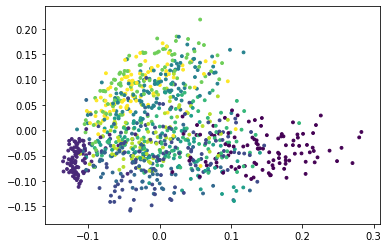

In [18]:
emb = RKPCA(X, 2, 600)
plot(emb, y)

In [19]:
#Reference
#from sklearn import manifold
#plot(manifold.TSNE(n_components=2).fit_transform(X), y)

In [20]:
#plot(manifold.TSNE(n_components=3).fit_transform(X), y)

# SVM Classification using Random Fourier Features Kernel

In [21]:
b = np.random.uniform(low=0, high = 2*np.pi, size=(1,m))
W = np.random.multivariate_normal(mean=np.zeros(d), cov=(2/d)*np.eye(d), size=m) # m x d

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

d = 784
m = 350

def getKernel(data):
    X = np.copy(data)
    n = X.shape[0] # number of data pts
    d = X.shape[1] # dimensionality of data

    Z = np.empty((n,m))
    Z = np.cos(X @ W.T + b) # n x m
    K = 1/m * Z @ Z.T
    
    return K

def ker(x, y):
    z1 = np.cos(x @ W.T + b)
    z2 = np.cos(y @ W.T + b)
    return (1/m) * (z1 @ z2.T)

In [23]:
#Classification: using first 10,000 imgs

X = full_X[:10000]
y = full_y[:10000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

st = perf_counter()
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
score1 = svm.score(X_test, y_test)
t1 = perf_counter() - st


iterations = 100
scores = np.empty(iterations)
times = np.empty(iterations)

for i in tqdm(range(iterations)):
    
    b = np.random.uniform(low=0, high = 2*np.pi, size=(1,m))
    W = np.random.multivariate_normal(mean=np.zeros(d), cov=(2/d)*np.eye(d), size=m) # m x d

    
    st = perf_counter()
    random_svm = SVC(kernel=ker)
    random_svm.fit(X_train, y_train)
    scores[i] = random_svm.score(X_test, y_test)
    times[i] = perf_counter() - st


In [24]:
print(f'Gaussian kernel: Accuracy: {score1}, time: {t1}')
print(f'Random kernel: Mean accuracy: {np.mean(scores)}, stdev: {np.std(scores)}, mean time: {np.mean(times)}')
print(f'Acc. stats: Min: {np.min(scores)}, 0.25: {np.quantile(scores, 0.25)}, median: {np.median(scores)}, 0.75: {np.quantile(scores,0.75)}, max: {np.max(scores)}')


Gaussian kernel: Accuracy: 0.9195, time: 36.9388929
Random kernel: Mean accuracy: 0.89028, stdev: 0.004241061187957564, mean time: 2.511569925999998
Acc. stats: Min: 0.881, 0.25: 0.8875, median: 0.8895, 0.75: 0.893, max: 0.9005


## Plot Accuracy as a function of gamma for deterministic gaussian kernel

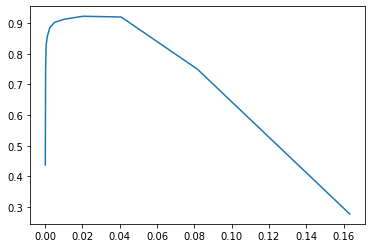

In [25]:
#Using first 2000 imgs

X = full_X[:2000]
y = full_y[:2000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

domain = (1/784) * np.asarray([.125,.25,.5,1,2,4,8,16,32,64,128])
scores = np.empty(domain.shape[0])

for i,val in enumerate(domain):
    svm = SVC(gamma=val)
    svm.fit(X_train, y_train)
    scores[i] = svm.score(X_test, y_test)
    
plt.plot(domain,scores)


In [26]:
scores

array([0.4375, 0.7475, 0.83  , 0.8575, 0.885 , 0.9025, 0.9125, 0.9225,
       0.92  , 0.75  , 0.2775])

## Investigate for changing covariance

In [27]:
def randomizedTrial(X_train, X_test, y_train, y_test, covariance):
    
    b = np.random.uniform(low=0, high = 2*np.pi, size=(1,m))
    W = np.random.multivariate_normal(mean=np.zeros(d), cov=(2*covariance)*np.eye(d), size=m) # m x d

    def ker(x, y):
        z1 = np.cos(x @ W.T + b)
        z2 = np.cos(y @ W.T + b)
        return (1/m) * (z1 @ z2.T)
    
    random_svm = SVC(kernel=ker)
    random_svm.fit(X_train, y_train)
    return random_svm.score(X_test, y_test)
    
iterations = 10
scores = np.empty((domain.shape[0],iterations))
    
for i,val in enumerate(domain):
    for j in range(iterations):
        scores[i][j] = randomizedTrial(X_train, X_test, y_train, y_test, val)
        
# compute statistical information:

stat = np.empty((7, domain.shape[0]))
for i in range(domain.shape[0]):
    stat[0][i] = np.min(scores[i])
    stat[1][i] = np.quantile(scores[i], 0.25)
    stat[2][i] = np.median(scores[i])
    stat[3][i] = np.quantile(scores[i], 0.75)
    stat[4][i] = np.max(scores[i])
    stat[5][i] = np.mean(scores[i])
    stat[6][i] = np.std(scores[i])

    

Text(0.5, 1.0, "Randomized Kernel SVM accuracy 'continuous boxplot'")

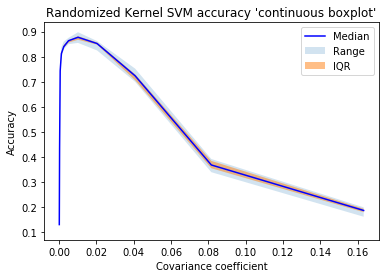

In [28]:
plt.plot(domain, stat[2], c='b', label='Median')
plt.fill_between(domain, stat[4], stat[0], alpha=0.2, label='Range', lw=1)
plt.fill_between(domain, stat[1], stat[3], alpha=0.5, label='IQR', lw=1)
plt.xlabel('Covariance coefficient')
plt.ylabel('Accuracy')
#plt.set_yscale('log')
plt.legend(loc='upper right')
plt.title('Randomized Kernel SVM accuracy \'continuous boxplot\'')

## Accuracy as a function of the low dimension parameter m

In [29]:
m_domain = np.asarray([10, 50, 100, 200, 400, 750])

def randomizedTrial(X_train, X_test, y_train, y_test, m):
    
    b = np.random.uniform(low=0, high = 2*np.pi, size=(1,m))
    W = np.random.multivariate_normal(mean=np.zeros(d), cov=(2/784)*np.eye(d), size=m) # m x d

    def ker(x, y):
        z1 = np.cos(x @ W.T + b)
        z2 = np.cos(y @ W.T + b)
        return (1/m) * (z1 @ z2.T)
    
    random_svm = SVC(kernel=ker)
    random_svm.fit(X_train, y_train)
    return random_svm.score(X_test, y_test)
    
iterations = 10
scores = np.empty((m_domain.shape[0],iterations))
    
for i,val in enumerate(m_domain):
    for j in range(iterations):
        scores[i][j] = randomizedTrial(X_train, X_test, y_train, y_test, val)
        
# compute statistical information:

stat = np.empty((7, m_domain.shape[0]))
for i in range(m_domain.shape[0]):
    stat[0][i] = np.min(scores[i])
    stat[1][i] = np.quantile(scores[i], 0.25)
    stat[2][i] = np.median(scores[i])
    stat[3][i] = np.quantile(scores[i], 0.75)
    stat[4][i] = np.max(scores[i])
    stat[5][i] = np.mean(scores[i])
    stat[6][i] = np.std(scores[i])

    


Text(0.5, 1.0, 'Randomized Kernel SVM accuracy as a function of m')

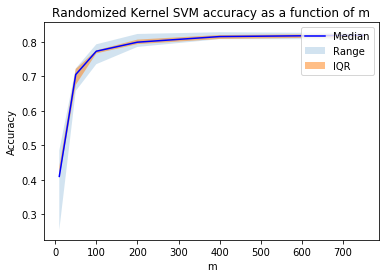

In [30]:
plt.plot(m_domain, stat[2], c='b', label='Median')
plt.fill_between(m_domain, stat[4], stat[0], alpha=0.2, label='Range', lw=1)
plt.fill_between(m_domain, stat[1], stat[3], alpha=0.5, label='IQR', lw=1)
plt.xlabel('m')
plt.ylabel('Accuracy')
#plt.set_yscale('log')
plt.legend(loc='upper right')
plt.title('Randomized Kernel SVM accuracy as a function of m')

## Plotting code for KPCA demonstration with slider widget

Often needs to be run twice to actually work, not sure why

In [31]:
%matplotlib notebook

<IPython.core.display.Javascript object>


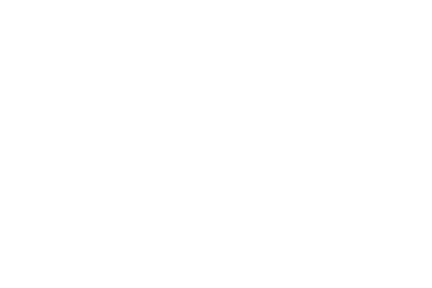

interactive(children=(FloatSlider(value=0.5, description='gamma', max=30.0, step=0.01), Output()), _dom_classe…

<function __main__.update(gamma)>

<IPython.core.display.Javascript object>


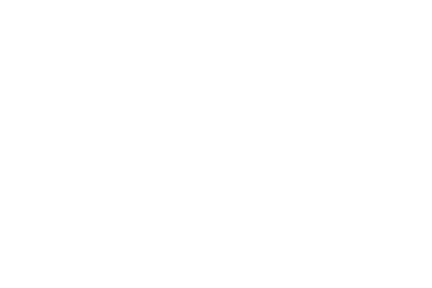

In [32]:
# TEST cell for plotting
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

plt.ion()

emb = KernelPCA(n_components=2, kernel='rbf', gamma=0.5).fit_transform(data)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
outer, = ax.plot(emb.T[0][:100],emb.T[1][:100],marker='o', linestyle='', color='y')
inner, = ax.plot(emb.T[0][100:200],emb.T[1][100:200],marker='o', linestyle='', color='purple')

def update(gamma):
    emb = KernelPCA(n_components=2, kernel='rbf', gamma=gamma).fit_transform(data)
    outer.set_xdata(emb.T[0][:100])
    outer.set_ydata(emb.T[1][:100])
    inner.set_xdata(emb.T[0][100:200])
    inner.set_ydata(emb.T[1][100:200])
    
    fig.canvas.draw_idle()

interact(update, gamma = widgets.FloatSlider(value=0.5,min=0,max=30,step=0.01))

### Code used to create GIF of RKPCA

In [33]:
#%matplotlib inline

In [34]:
# domain = np.square(np.arange(0.02,5,0.02))

# for i,value in enumerate(domain):
#     emb = KernelPCA(n_components=2, kernel='rbf', gamma=value).fit_transform(data)
#     plt.scatter(emb.T[0],emb.T[1], s=8, c=colormap)
#     plt.ylim(-0.7, 0.7)
#     plt.xlim(-0.7, 0.7)
#     plt.savefig('temp/img'+str(i).zfill(4)+'.png')
#     plt.clf()